__Purpose:__ Before implementing Federated Learning, re-implement the original simulatinos on the continuous data task we've been working off of to ensure that we implement the correct loss functions in the federated learning task. Simulated decoders should match the decoders found in Ws_block1 from the CPHS data pickle file.
<br>
1. The dec matrix is the weights to pass back and forth, although it comes out of SmoothBatch first
1. We are assuming we can test on the second half (updates 10-19ish) since learning should be complete by then!
1. Scipy.optimize.minimize() runs many iters to fully minimize its cost function.  You can change it to run as many iters as you'd like, although AFAIK you won't know how many it takes to converge.  But this is still a good set up for FL.
1. Hmm minimize() is doing BFGS rn and not SGD... not sure if that matters really.  Could probably implement SGD on my own or find it.  BFGS is 2nd order but we don't have a lot of parameters, I don't think.  Plus we can (already have?) solved analytically for the Hessian.  I think.

In [1]:
import pandas as pd
import os
import numpy as np
#from numpy.matlib import repmat
from matplotlib import pyplot as plt
#from scipy.signal import detrend, firwin, freqz, lfilter
#from sklearn.model_selection import train_test_split, ShuffleSplit
from scipy.optimize import minimize, least_squares
import copy
from itertools import permutations

In [2]:
from experiment_params import *
from simulations import *
import time
import pickle

# Reminder of Conditions Order

NOTE: 

* **CONDITIONS** = array(['D_1', 'D_2', 'D_5', 'D_6', 'D_3', 'D_4', 'D_7','D_8']
* **LEARNING RATES:** alpha = 0.25 and 0.75; alpha = 0.25 for D1, D2, D5, D6; alpha = 0.75 for D3, D4, D7, D8
* **SMOOTHBATCH:** W_next = alpha*W_old + ((1 - alpha) * W_calc)

* **DECODER INIT:** pos for D1 - D4, neg for D5 - D8

* **PENALTY TERM:** $\lambda_E$ = 1e-6 for all, $\lambda_F$ = 1e-7 for all, $\lambda_D$ = 1e-3 for 1, 3, 5, 7 and 1e-4 for 2, 4, 6, 8 


| DECODER | ALPHA | PENALTY | DEC INIT |
| --- | --- | --- | --- |
| 1 | 0.25 | 1e-3 | + |
| 2 | 0.25 | 1e-4 | + |
| 3 | 0.75 | 1e-3 | + |
| 4 | 0.75 | 1e-4 | + |
| 5 | 0.25 | 1e-3 | - |
| 6 | 0.25 | 1e-4 | - |
| 7 | 0.75 | 1e-3 | - |
| 8 | 0.75 | 1e-4 | - |


## Load Our Data In

In [3]:
t0 = time.time()

with open('Data\continuous_full_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, Ws_block1, _, _, _, _, _ = pickle.load(handle)

#with open('Data\continuous_full_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    #refs_block2, _, _, _, emgs_block2, Ws_block2, _, _, _, _, _ = pickle.load(handle)

t1 = time.time()
total = t1-t0  
print(total)

10.61870789527893


In [4]:
# 8 conditions, 20770 data points (only 19 unique sets!), xy, channels
Ws_block1[keys[0]].shape

(8, 20770, 2, 64)

In [5]:
update_ix

array([    0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614,
       10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432,
       20769])

In [6]:
dec_cond0_user1_update0 = Ws_block1[keys[0]][0,0,:,:]
dec_cond0_user1_update1 = Ws_block1[keys[0]][0,update_ix[1],:,:]
dec_cond0_user1_update2 = Ws_block1[keys[0]][0,update_ix[2],:,:]

print(f"Shape of decoder: {dec_cond0_user1_update0.shape}")
print()
print(f"Total difference between dec0 and dec1: {(dec_cond0_user1_update0 - dec_cond0_user1_update1).sum()}")
print("E.g., as previously shown, the first two decs are the same")
print()
print(f"Total difference between dec0 and dec2: {(dec_cond0_user1_update0 - dec_cond0_user1_update2).sum()}")

Shape of decoder: (2, 64)

Total difference between dec0 and dec1: 0.0
E.g., as previously shown, the first two decs are the same

Total difference between dec0 and dec2: 3.1981579823181594


In [7]:
#emg_cond0_user1_update0 = emg_data_df.iloc[:64,:].shape

# (Condition, datapoints, channels)
print(emgs_block1[keys[0]][:,:,:].shape)

# Condition 0 of subject 1 ("0")
print(emgs_block1[keys[0]][0,:,:].shape)

(8, 20770, 64)
(20770, 64)


## Run One Iteration On Above Data and Check Decoders Are the Same
1. Modifying Simulations Code

In [8]:
# For condition 1:
alpha = .25 # higher alpha means more old decoder (slower update)
# Assuming these are the same as lambda's, the decoder cost penalties
alphaF = 1e-7
alphaD = 1e-3
#where is lambda E?

Condition 0 only for now

In [32]:
first_half = 7

# Added 2 new parameters
#def simulation(D,learning_batch,alpha,alphaF=1e-2,alphaD=1e-2,display_info=False,num_iters=False):
display_info=False
num_updates = 19  # This is 19 for us
dt = 1/60

D = [[0 for _ in range(num_updates)] for i in range(first_half)]
cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]
grad_cost_log = [[0 for _ in range(num_updates)] for i in range(first_half)]

for idx, user in enumerate(keys[:first_half]):
    filtered_signals = emgs_block1[user][0,:,:]
    p_reference_full = refs_block1[user][0,:,:]
    D[idx][0] = Ws_block1[user][0,0,:,:]
    total_datapoints = emgs_block1[user][0,:,:].shape[0]
    # batches the trials into each of the update batch
    # Do num_updates-1 because the very last update is only 1 datapoint, the 2nd to last is only 337
    for ix in range(num_updates-1):
        ix+=1  # I think this might make it skip the 1st update (eg update 0) --> I changed it to ix-1, ix
        # Reason is because it lets us do D[idx][ix-1] to get the init dec
        #print(ix)

        # Instead of using learning_batch, we should get the same results just using update_ix values
        lower_bound = update_ix[ix-1]
        if ix==(num_updates-1):
            upper_bound = total_datapoints
        else:
            upper_bound = update_ix[ix]
        learning_batch = upper_bound - lower_bound

        s = np.transpose(filtered_signals[lower_bound:upper_bound,:])
        v_actual = D[idx][ix-1]@s
        # Numerical integration of v_actual to get p_actual
        p_actual = np.sum(v_actual, axis=1)*dt  # dt=1/60
        p_actual = np.reshape(p_actual, (p_actual.shape[0], 1))
        # Update decoder
        p_reference = np.transpose(p_reference_full[lower_bound:upper_bound,:])
        #(r-y)/60=D_new@s  # This is the optimization problem
        V = (p_reference - p_actual)*dt
        F = copy.deepcopy(s[:,:-1]) # note: truncate F for estimate_decoder # why?

        # set alphas
        H = np.zeros((2,2))
        # use scipy minimize for gradient descent and provide pre-computed analytical gradient for speed
        # Is using D[-1] the same as solving the lambda min D function?
        cost_log[idx][ix] = cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        grad_cost_log[idx][ix] = gradient_cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD)
        out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})
        #out = minimize(lambda D: cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D[idx][ix-1],H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})
        #out = minimize(lambda lam_x: cost_l2(F,lam_x,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,lam_x,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})
        
        # reshape to decoder parameters
        W_hat = np.reshape(out.x,(2, 64))

        # DO SMOOTHBATCH
        W_new = alpha*D[idx][ix-1] + ((1 - alpha) * W_hat)
        D[idx][ix] = W_new

C:\Users\kdmen\AppData\Local\Temp\ipykernel_10016\1068899154.py:50: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  out = minimize(lambda D: cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), D[idx][ix-1], method='BFGS', jac=lambda D: gradient_cost_l2(F,D,H,V,learning_batch,alphaF,alphaD), options={'disp': display_info})


In [33]:
# The first instance where they could concievable have the same dec value is the 3rd dec in Ws_block (AKA index 2)
#print((D[1] - Ws_block1[keys[0]][0,update_ix[2],:,:]).sum())
print((D[0][1] - Ws_block1[keys[0]][0,update_ix[2],:,:]).sum())

2.2184923272665014


In [34]:
# Check how different the final decs are, this is all we really care about
# Although if the earlier decs are different how could the last ones be the same lol
print((D[0][-1] - Ws_block1[keys[0]][0,update_ix[-1],:,:]).sum())

2.476576505327882


In [35]:
# Differences between consecutive decoders

# From this file
print(f"Length of D (sims code): {len(D)}")
print(f"Length of Ws_block1 (cphs code): {len(update_ix)}")
print()
print("Labels;       D (Sims);     Ws (CPHS);     Sim - CPHS")
for i in range(len(D)-2):
    print(f"Dec{i+1} - Dec{i}: {(D[0][i+1] - D[0][i]).sum():9.5f};    {(Ws_block1[keys[0]][0,update_ix[i+1],:,:] - Ws_block1[keys[0]][0,update_ix[i],:,:]).sum():9.5f};      {(D[i] - Ws_block1[keys[0]][0,update_ix[i],:,:]).sum():9.5f}")

Length of D (sims code): 7
Length of Ws_block1 (cphs code): 19

Labels;       D (Sims);     Ws (CPHS);     Sim - CPHS
Dec1 - Dec0:  -0.97967;      0.00000;      -12.33865
Dec2 - Dec1:   0.28448;     -3.19816;      -21.27982
Dec3 - Dec2:   0.03778;      8.21960;       49.67734
Dec4 - Dec3:  -0.01949;     -7.00649;      -106.09134
Dec5 - Dec4:   0.06411;      2.21186;       25.42778


In [36]:
# Adding one to account for the fact that Ws_block 0 and 1 are the same.
for i in range(len(D)-2):
    print(f"{(D[0][i] - Ws_block1[keys[0]][0,update_ix[i+1],:,:]).sum():9.5f}")

  0.00000
  2.21849
 -5.71662
  1.32766
 -0.90370


## Now try plotting the costs to see if it matches NB201

In [37]:
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}

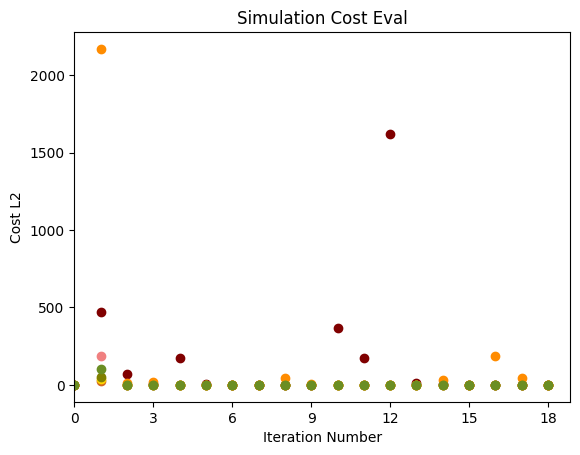

In [49]:
for i in range(first_half):
    for idx, update_cost in enumerate(cost_log[i]):
        plt.scatter(idx, update_cost, color=id2color[i])
        
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
#plt.ylim(0, 70)
plt.xticks(np.arange(0, 19, 3.0))
#plt.yticks(np.arange(0, 120, 20.0))
plt.show()

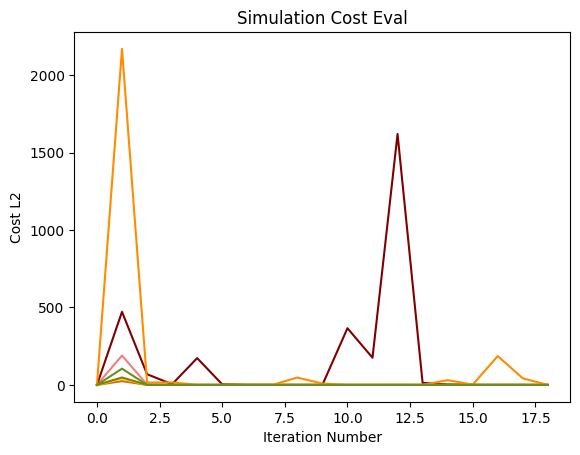

In [44]:
step_indices = list(range(19))
for i in range(first_half):
    plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
#plt.ylim(0, 70)
plt.show()

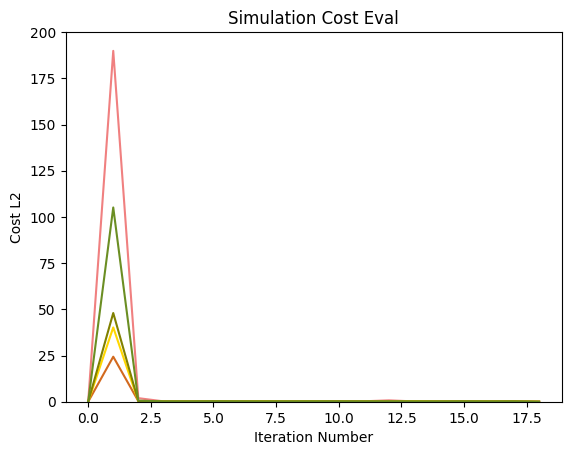

In [46]:
for i in range(first_half):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
plt.ylim(0, 200)
plt.show()

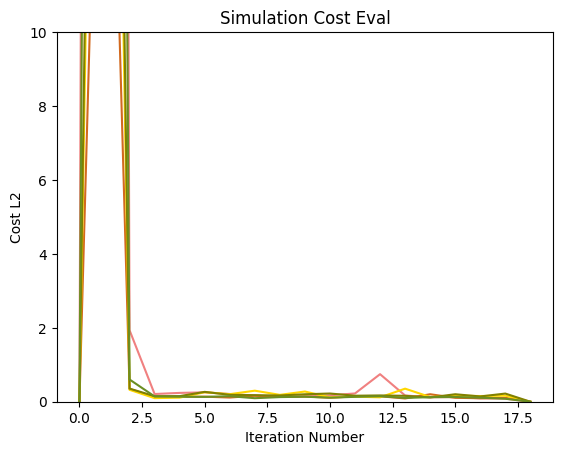

In [47]:
for i in range(first_half):
    if i in (1, 3, 13):
        pass
    else:
        plt.plot(step_indices, cost_log[i], color=id2color[i])
    
plt.ylabel('Cost L2')
plt.xlabel('Iteration Number')
plt.title('Simulation Cost Eval')
plt.ylim(0, 10)
plt.show()